<a href="https://www.kaggle.com/code/kaustubniraula/image-captioning-using-lstm?scriptVersionId=137666585" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import pickle

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [10]:
base_dir = "/kaggle/input/flickr8k"
working_dir = "/kaggle/working"

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add





In [4]:
model = VGG16()
model.summary()

553467096/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [5]:
model = Model(inputs = model.inputs , outputs = model.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
directory = os.path.join(base_dir, "images")
features = {}

In [ ]:
for img_name in os.listdir(directory):
    
    img_path = os.path.join(directory,img_name)
    img = load_img(img_path, target_size=(224,224))
    img = img_to_array(img)
    img = img.reshape((1,img.shape[0],img.shape[1],img.shape[2]))
    img = preprocess_input(img)
    feature = model.predict(img, verbose =0)
    img_id = img_name.split('.')[0]
    features[img_id] = feature

In [11]:
pickle.dump(features, open(os.path.join(working_dir,'features.pkl'),'wb'))

In [12]:
with open(os.path.join(working_dir,'features.pkl'),'rb') as f:
    features = pickle.load(f)

In [13]:
features['1000268201_693b08cb0e'][0]

array([2.5076475, 0.       , 0.       , ..., 0.       , 0.       ,
       0.       ], dtype=float32)

In [14]:
with open(os.path.join(base_dir,'captions.txt'),'r') as f:
    next(f)
    captions_doc = f.read() 

In [16]:
# captions_doc

mapping = {}
count = 0

In [20]:
count = 0
mapping = {}

for line in (captions_doc.split('\n')):
    try:
        tokens = line.lower().split('|')
        if len(tokens) < 3:
            continue
            
        img_id, cap_number, img_caption = tokens
        img_id  = img_id.split('.')[0]
        img_caption = str(img_caption.split('.')[0])
        
        if (len(img_caption) < 5):
            continue
        
        if img_id in mapping:
            if img_caption not in mapping[img_id]:
                mapping[img_id].append(img_caption)
            
        else:
            mapping[img_id] = []
            mapping[img_id].append(img_caption)
    except:
        continue

In [22]:
def preprocess(mapp):
    for key,value in mapp.items():
        for i in range(len(value)):
            cap = value[i]
            cap = 'startseq ' + ' '.join([word for word in cap.split() if len(word) > 1 ]) + ' endseq'
            cap = cap.replace('[^A-Za-z]' , '')
            cap = cap.replace('\s+' , '')
            value[i] = cap

In [23]:
preprocess(mapping)

In [24]:
text = []
for key,value in mapping.items():
    for i in value:
        text.append(i)

In [25]:
text[1000:1010]

['startseq black and brown dog is laying on white shaggy carpet endseq',
 'startseq brown and black dog is laying on shaggy rug endseq',
 'startseq small brown and black dog lying down in furry rug endseq',
 'startseq small dog is sitting on white carpet endseq',
 'startseq small dog shakes its head on white shag carpet endseq',
 'startseq smiling girls in bathing suits sitting on the sand endseq',
 'startseq group of friends smile for picture at the beach endseq',
 'startseq group of young ladies in bikinis endseq',
 'startseq the three girls in bathing suits are all smiles endseq',
 'startseq the three girls sat on the beach endseq']

In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)

vocab_size = len(tokenizer.word_index) + 1
vocab_size

8473

In [27]:
max_len = max([len(line.split()) for line in text])
max_len

34

In [28]:
img_keys = list(mapping.keys())

train_size = int(len(img_keys) * 0.8)
val_size = int(len(img_keys) * 0.1)

train = img_keys[:train_size]
val = img_keys[train_size: (train_size + val_size)]
test = img_keys[(train_size + val_size):]

In [29]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [17]:
tokenizer

In [27]:
captions

NameError: name 'captions' is not defined

In [30]:
tokenizer.texts_to_sequences(mapping['1000268201_693b08cb0e'])

[[1, 42, 3, 89, 171, 6, 117, 50, 392, 11, 393, 3, 27, 5138, 670, 2],
 [1, 18, 315, 63, 195, 115, 2],
 [1, 39, 18, 117, 63, 195, 2429, 2],
 [1, 39, 18, 117, 4, 393, 19, 59, 2429, 2],
 [1, 39, 18, 3, 89, 171, 315, 63, 195, 2972, 2]]

In [31]:
def data_generator(mapping, features, batch_size, max_len, img_keys, tokenizer, vocab_size):
    X1,X2,y = [],[],[]
    n = 0
    
    while 1:
        
        for key in img_keys:
            n += 1
            captions = mapping[key]
            captions = tokenizer.texts_to_sequences(captions)
            
            for caption in captions:    
                for i in range(1,len(caption)):
                    in_seq, out_seq = caption[:i],caption[i]
                    
                    in_seq = pad_sequences([in_seq], padding='post', maxlen= max_len)[0]
                    
                    out_seq = to_categorical([out_seq],num_classes = vocab_size)[0]
                    
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1,X2] , y
                n = 0
                X1,X2,y = [],[],[]

In [39]:
# a = tokenizer.texts_to_sequences(mapping[train[0]])

# for caption in a:   
#     for i in range(1,len(caption)):
#         in_seq, out_seq = caption[:i],caption[i]
        
#         in_seq = pad_sequences([in_seq],padding='post', maxlen= max_len)
        
#         out_seq = to_categorical([out_seq], 
#            num_classes=vocab_size)[0]
        
#         print(in_seq,out_seq)
                

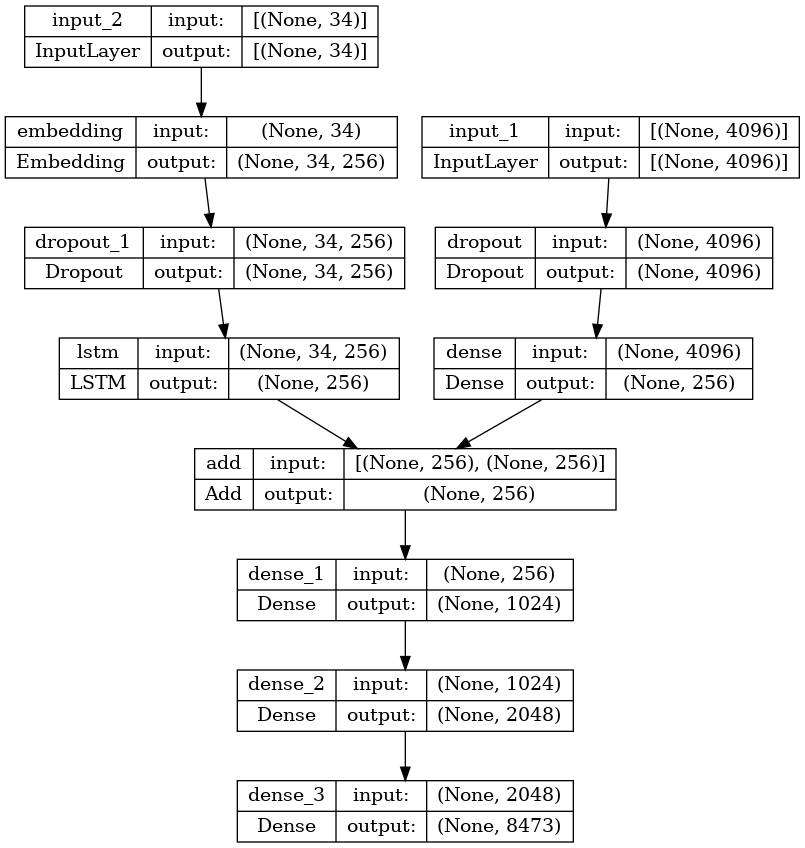

In [32]:
inputs1 = Input(shape = (4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256,activation = 'relu')(fe1)

inputs2 = Input(shape = (max_len,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
de1 = Dropout(0.4)(se1)
de2 = LSTM(256)(de1)

e = add( [fe2, de2] )
e1 = Dense(1024, activation = 'relu')(e)
e2 = Dense(2048, activation = 'relu')(e1)
output = Dense(vocab_size, activation = 'softmax')(e2)

model = Model(inputs = [inputs1,inputs2], outputs = output)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

plot_model(model, show_shapes=True)


In [33]:
epochs = 100
batch_size = 32
step_size = len(img_keys) // batch_size

data = data_generator(mapping, features, batch_size, max_len, img_keys, tokenizer, vocab_size)

model.fit(data, epochs = epochs, steps_per_epoch=step_size, verbose = 1)

Epoch 1/100
252/252 [==============================] - 60s 205ms/step - loss: 5.1292
Epoch 2/100
252/252 [==============================] - 51s 201ms/step - loss: 3.9252
Epoch 3/100
252/252 [==============================] - 51s 203ms/step - loss: 3.5093
Epoch 4/100
252/252 [==============================] - 51s 204ms/step - loss: 3.2332
Epoch 5/100
252/252 [==============================] - 51s 201ms/step - loss: 3.0095
Epoch 6/100
252/252 [==============================] - 51s 203ms/step - loss: 2.8424
Epoch 7/100
252/252 [==============================] - 51s 202ms/step - loss: 2.7165
Epoch 8/100
252/252 [==============================] - 51s 203ms/step - loss: 2.6107
Epoch 9/100
252/252 [==============================] - 51s 203ms/step - loss: 2.5216
Epoch 10/100
252/252 [==============================] - 51s 203ms/step - loss: 2.4287
Epoch 11/100
252/252 [==============================] - 51s 204ms/step - loss: 2.3499
Epoch 12/100
252/252 [==============================] - 51s 201

In [30]:
Pkl_Filename = "Model.pkl"  

In [35]:


# with open(Pkl_Filename, 'wb') as file:  
#     pickle.dump(model, file)

In [31]:
with open(Pkl_Filename, 'rb') as file:  
    model = pickle.load(file)

In [59]:
# seq = pad_sequences([tokenizer.texts_to_sequences(['startseq'])[0]]
#                             ,max_len,padding= 'post')

# image = features['1000268201_693b08cb0e']

# yhat = model.predict([image, seq],verbose = 1)


1/1 [==============================] - 0s 19ms/step


In [6]:
# a = yhat.argmax()

# for word,index in tokenizer.word_index.items():
#         if index == a:
#             print(word)

NameError: name 'yhat' is not defined

In [48]:
def idx_to_word(integer, tokenizer):
    for word,index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(m,tokenizer,max_len,image):
    
    in_text = 'startseq'
    
    for i in range(max_len):
        seq = pad_sequences([tokenizer.texts_to_sequences([in_text])[0]]
                            ,max_len,padding= 'post')
        
        yhat = m.predict([image ,seq],verbose = 0)
        yhat = np.argmax(yhat)
        
        word = idx_to_word(yhat, tokenizer)
        
        if word is None:
            break
        
        in_text += " " + word
        
        if word == 'endseq':
            break   
    return in_text

In [ ]:
bleu = []
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in test:
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, tokenizer, max_len, features[key])
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
    # calcuate BLEU score
bleu.append([ "BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
,"BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)) ])

In [ ]:
print(bleu)

In [49]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(base_dir, "images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model,tokenizer, max_len, features[image_id])
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [50]:
img_keys[:10]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615',
 '1007320043_627395c3d8',
 '1009434119_febe49276a',
 '1012212859_01547e3f17',
 '1015118661_980735411b',
 '1015584366_dfcec3c85a']

---------------------Actual---------------------
startseq black and white dog is running in grassy garden surrounded by white fence endseq
startseq black and white dog is running through the grass endseq
startseq boston terrier is running in the grass endseq
startseq boston terrier is running on lush green grass in front of white fence endseq
startseq dog runs on the green grass near wooden fence endseq
--------------------Predicted--------------------
startseq one dog is playing on the grass with ball in his mouth endseq


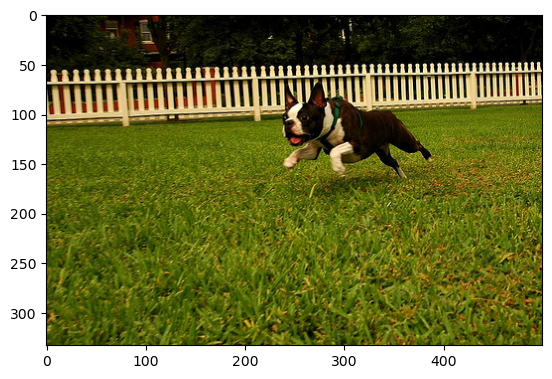

In [51]:
generate_caption("1009434119_febe49276a.jpg")

In [41]:
seq = pad_sequences([tokenizer.texts_to_sequences(['startseq'])[0]]
                            ,max_len,padding= 'post')
seq

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [47]:
yhat = model.predict([features["1009434119_febe49276a"] , seq],verbose = 0)
yhat = np.argmax(yhat)
idx_to_word(yhat, tokenizer)

'one'

8471